# Cercador model òptim de LSTM i GRU de dues capes

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import plotly.graph_objects as go
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error
from time import time

np.random.seed(2)
tf.random.set_seed(2)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras import backend

C:\Users\dj_kr\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Càrrega de les dades

In [2]:
df = pd.read_csv('data/SentDATA.csv')

df.reset_index(inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

## Transformació de dades

In [6]:
columns = ['PM1','PM25','PM10','PM1ATM','PM25ATM','PM10ATM']

df1 = df.copy();

df1 = df1.rename(columns={"PM 1":"PM1","PM 2.5":"PM25","PM 10":"PM10","PM 1 ATM":"PM1ATM","PM 2.5 ATM":"PM25ATM","PM 10 ATM":"PM10ATM"})

df1['PM1'] = df['PM 1'].astype(np.float32)
df1['PM25'] = df['PM 2.5'].astype(np.float32)
df1['PM10'] = df['PM 10'].astype(np.float32)
df1['PM1ATM'] = df['PM 1 ATM'].astype(np.float32)
df1['PM25ATM'] = df['PM 2.5 ATM'].astype(np.float32)
df1['PM10ATM'] = df['PM 10 ATM'].astype(np.float32)

In [11]:
df2 = df1.copy()

## Crear dades d'entrenament i de test

In [13]:
train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train, test = df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]
train.shape, test.shape

((3991, 7), (998, 7))

## Normalitzar les dades d'entrenament

In [14]:
#Standardize the data
for col in columns:
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[[col]])


<ipython-input-14-ad7c79e4e223>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-ad7c79e4e223>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-ad7c79e4e223>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-14-ad7c79e

## Crear finestra de temps PM 2.5

In [15]:
TIME_STEPS=144 #6 registres hora x 24h x 3 --> equival a una finestra d'un dia

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train1h, y_train1h = create_sequences(train[[columns[1]]], train[columns[1]], 6) #1 hour

X_train3h, y_train3h = create_sequences(train[[columns[1]]], train[columns[1]], 18) #3 hours

X_train6h, y_train6h = create_sequences(train[[columns[1]]], train[columns[1]], 36) #6 hours

X_train12h, y_train12h = create_sequences(train[[columns[1]]], train[columns[1]], 72) #12 hours

X_train1d, y_train1d = create_sequences(train[[columns[1]]], train[columns[1]], 144) #1 day

X_train3d, y_train3d = create_sequences(train[[columns[1]]], train[columns[1]], 432) #3 days

X_train7d, y_train7d = create_sequences(train[[columns[1]]], train[columns[1]], 1008) #7 days
#X_test, y_test = create_sequences(test[[columns[1]]], test[columns[1]])

print(f'X_train1h shape: {X_train1d.shape}')
print(f'X_train3d shape: {X_train3h.shape}')
print(f'X_train6h shape: {X_train6h.shape}')
print(f'X_train12h shape: {X_train12h.shape}')
print(f'X_train1d shape: {X_train1d.shape}')
print(f'X_train3d shape: {X_train3d.shape}')
print(f'X_train7d shape: {X_train7d.shape}')

X_train1h shape: (3847, 144, 1)
X_train3d shape: (3973, 18, 1)
X_train6h shape: (3955, 36, 1)
X_train12h shape: (3919, 72, 1)
X_train1d shape: (3847, 144, 1)
X_train3d shape: (3559, 432, 1)
X_train7d shape: (2983, 1008, 1)


In [16]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Square Error: {:.4f}'.format(mse))
    print('')
    return mae,rmse,mse

## Cerca dels models òptims

###########################

MODEL:  LSTM
sequence:  1h
units:  43
dropout1:  0.40519643149940265
dropout2:  0.3312343747027119
optimizer: adam
activationDense: tanh
epochs: 56
batchsize: 11
validation_split: 0.1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 43)             7740      
_________________________________________________________________
dropout (Dropout)            (None, 6, 43)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 43)             14964     
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 43)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 1)              44        
Total params: 22,748
Trainable params: 22

107/107 [==============================] - 2s 16ms/step - loss: 0.5278 - val_loss: 0.3699
Epoch 2/43
107/107 [==============================] - 1s 7ms/step - loss: 0.3832 - val_loss: 0.3112
Epoch 3/43
107/107 [==============================] - 1s 7ms/step - loss: 0.3322 - val_loss: 0.2638
Epoch 4/43
107/107 [==============================] - 1s 7ms/step - loss: 0.2965 - val_loss: 0.2365
Epoch 5/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2806 - val_loss: 0.2270
Epoch 6/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2749 - val_loss: 0.2234
Epoch 7/43
107/107 [==============================] - 1s 7ms/step - loss: 0.2741 - val_loss: 0.2225
Epoch 8/43
107/107 [==============================] - 1s 7ms/step - loss: 0.2723 - val_loss: 0.2210
Epoch 9/43
107/107 [==============================] - 1s 7ms/step - loss: 0.2724 - val_loss: 0.2208
Epoch 10/43
107/107 [==============================] - 1s 7ms/step - loss: 0.2712 - val_loss: 0.2180
Epoch 11/

107/107 [==============================] - 1s 7ms/step - loss: 0.4947 - val_loss: 0.6624
Epoch 37/43
107/107 [==============================] - 1s 7ms/step - loss: 0.4945 - val_loss: 0.6627
Epoch 38/43
107/107 [==============================] - 1s 7ms/step - loss: 0.4948 - val_loss: 0.6625
Epoch 39/43
107/107 [==============================] - 1s 8ms/step - loss: 0.4945 - val_loss: 0.6620
Epoch 40/43
107/107 [==============================] - 1s 8ms/step - loss: 0.4943 - val_loss: 0.6625
Epoch 41/43
107/107 [==============================] - 1s 8ms/step - loss: 0.4943 - val_loss: 0.6622
Epoch 42/43
107/107 [==============================] - 1s 7ms/step - loss: 0.4942 - val_loss: 0.6622
Epoch 43/43
107/107 [==============================] - 1s 7ms/step - loss: 0.4945 - val_loss: 0.6622
Execution time:  41.00082015991211
LSTM:
Mean Absolute Error: 0.4926
Root Mean Square Error: 0.7513
Mean Square Error: 0.5645

Train RMSE: 0.751
Train MSE: 0.564
Train MAE: 0.493
#########################

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 6, 45)             8460      
_________________________________________________________________
dropout_10 (Dropout)         (None, 6, 45)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 6, 45)             16380     
_________________________________________________________________
dropout_11 (Dropout)         (None, 6, 45)             0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 6, 1)              46        
Total params: 24,886
Trainable params: 24,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/43
107/107 [==============================] - 2s 20ms/step - loss: 0.7196 - val_loss: 0.7078
Epoch 2/43
107/

107/107 [==============================] - 1s 8ms/step - loss: 0.8769 - val_loss: 1.1357
Epoch 27/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8768 - val_loss: 1.1356
Epoch 28/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8768 - val_loss: 1.1355
Epoch 29/43
107/107 [==============================] - 1s 7ms/step - loss: 0.8767 - val_loss: 1.1354
Epoch 30/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8766 - val_loss: 1.1353
Epoch 31/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8766 - val_loss: 1.1352
Epoch 32/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8765 - val_loss: 1.1350
Epoch 33/43
107/107 [==============================] - 1s 7ms/step - loss: 0.8765 - val_loss: 1.1349
Epoch 34/43
107/107 [==============================] - 1s 7ms/step - loss: 0.8764 - val_loss: 1.1348
Epoch 35/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8763 - val_loss: 1.1347
Ep

326/326 [==============================] - 1s 5ms/step - loss: 0.2670 - val_loss: 0.1256
Epoch 49/56
326/326 [==============================] - 2s 5ms/step - loss: 0.2664 - val_loss: 0.1215
Epoch 50/56
326/326 [==============================] - 2s 5ms/step - loss: 0.2664 - val_loss: 0.1204
Epoch 51/56
326/326 [==============================] - 2s 5ms/step - loss: 0.2655 - val_loss: 0.1191
Epoch 52/56
326/326 [==============================] - 1s 5ms/step - loss: 0.2658 - val_loss: 0.1186
Epoch 53/56
326/326 [==============================] - 1s 5ms/step - loss: 0.2659 - val_loss: 0.1149
Epoch 54/56
326/326 [==============================] - 1s 5ms/step - loss: 0.2652 - val_loss: 0.1169
Epoch 55/56
326/326 [==============================] - 2s 5ms/step - loss: 0.2650 - val_loss: 0.1155
Epoch 56/56
326/326 [==============================] - 2s 5ms/step - loss: 0.2648 - val_loss: 0.1142
Execution time:  91.40200185775757
LSTM:
Mean Absolute Error: 0.1623
Root Mean Square Error: 0.5744
Mea

107/107 [==============================] - 1s 7ms/step - loss: 0.5263 - val_loss: 0.6723
Epoch 14/43
107/107 [==============================] - 1s 7ms/step - loss: 0.5251 - val_loss: 0.6712
Epoch 15/43
107/107 [==============================] - 1s 7ms/step - loss: 0.5243 - val_loss: 0.6703
Epoch 16/43
107/107 [==============================] - 1s 7ms/step - loss: 0.5235 - val_loss: 0.6696
Epoch 17/43
107/107 [==============================] - 1s 8ms/step - loss: 0.5229 - val_loss: 0.6690
Epoch 18/43
107/107 [==============================] - 1s 8ms/step - loss: 0.5224 - val_loss: 0.6685
Epoch 19/43
107/107 [==============================] - 1s 8ms/step - loss: 0.5219 - val_loss: 0.6679
Epoch 20/43
107/107 [==============================] - 1s 8ms/step - loss: 0.5212 - val_loss: 0.6673
Epoch 21/43
107/107 [==============================] - 1s 7ms/step - loss: 0.5203 - val_loss: 0.6668
Epoch 22/43
107/107 [==============================] - 1s 8ms/step - loss: 0.5195 - val_loss: 0.6663
Ep

325/325 [==============================] - 3s 10ms/step - loss: 0.3332 - val_loss: 0.1771
Epoch 38/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3335 - val_loss: 0.1725
Epoch 39/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3331 - val_loss: 0.1706
Epoch 40/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3325 - val_loss: 0.1653
Epoch 41/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3323 - val_loss: 0.1657
Epoch 42/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3326 - val_loss: 0.1653
Epoch 43/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3318 - val_loss: 0.1607
Epoch 44/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3319 - val_loss: 0.1581
Epoch 45/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3315 - val_loss: 0.1585
Epoch 46/56
325/325 [==============================] - 3s 10ms/step - loss: 0.3312 - val_loss:

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 18, 43)            7740      
_________________________________________________________________
dropout_28 (Dropout)         (None, 18, 43)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 18, 43)            14964     
_________________________________________________________________
dropout_29 (Dropout)         (None, 18, 43)            0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, 18, 1)             44        
Total params: 22,748
Trainable params: 22,748
Non-trainable params: 0
_________________________________________________________________
Epoch 1/56
325/325 [==============================] - 4s 13ms/step - loss: 0.6606 - val_loss: 0.8320
Epoch 2/56
325

325/325 [==============================] - 3s 10ms/step - loss: 0.6666 - val_loss: 0.7185
Epoch 25/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6641 - val_loss: 0.7134
Epoch 26/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6615 - val_loss: 0.7081
Epoch 27/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6587 - val_loss: 0.7027
Epoch 28/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6563 - val_loss: 0.6972
Epoch 29/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6534 - val_loss: 0.6915
Epoch 30/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6507 - val_loss: 0.6857
Epoch 31/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6480 - val_loss: 0.6797
Epoch 32/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6448 - val_loss: 0.6735
Epoch 33/56
325/325 [==============================] - 3s 10ms/step - loss: 0.6417 - val_loss:

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 18, 45)            8460      
_________________________________________________________________
dropout_38 (Dropout)         (None, 18, 45)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 18, 45)            16380     
_________________________________________________________________
dropout_39 (Dropout)         (None, 18, 45)            0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 1)             46        
Total params: 24,886
Trainable params: 24,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/43
106/106 [==============================] - 3s 25ms/step - loss: 0.8843 - val_loss: 1.1420
Epoch 2/43
106

106/106 [==============================] - 2s 16ms/step - loss: 0.3341 - val_loss: 0.2611
Epoch 25/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3332 - val_loss: 0.2604
Epoch 26/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3330 - val_loss: 0.2599
Epoch 27/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3323 - val_loss: 0.2593
Epoch 28/43
106/106 [==============================] - 2s 17ms/step - loss: 0.3322 - val_loss: 0.2586
Epoch 29/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3314 - val_loss: 0.2584
Epoch 30/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3314 - val_loss: 0.2581
Epoch 31/43
106/106 [==============================] - 2s 17ms/step - loss: 0.3311 - val_loss: 0.2578
Epoch 32/43
106/106 [==============================] - 2s 15ms/step - loss: 0.3308 - val_loss: 0.2574
Epoch 33/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3304 - val_loss:

324/324 [==============================] - 9s 27ms/step - loss: 0.5046 - val_loss: 0.3819
Epoch 2/56
324/324 [==============================] - 8s 23ms/step - loss: 0.4459 - val_loss: 0.3214
Epoch 3/56
324/324 [==============================] - 8s 24ms/step - loss: 0.4292 - val_loss: 0.2924
Epoch 4/56
324/324 [==============================] - 8s 23ms/step - loss: 0.4216 - val_loss: 0.2774
Epoch 5/56
324/324 [==============================] - 8s 24ms/step - loss: 0.4174 - val_loss: 0.2698
Epoch 6/56
324/324 [==============================] - 8s 24ms/step - loss: 0.4150 - val_loss: 0.2635
Epoch 7/56
324/324 [==============================] - 8s 24ms/step - loss: 0.4134 - val_loss: 0.2591
Epoch 8/56
324/324 [==============================] - 8s 24ms/step - loss: 0.4123 - val_loss: 0.2584
Epoch 9/56
324/324 [==============================] - 8s 24ms/step - loss: 0.4113 - val_loss: 0.2556
Epoch 10/56
324/324 [==============================] - 8s 24ms/step - loss: 0.4116 - val_loss: 0.2541


Epoch 12/43
106/106 [==============================] - 3s 27ms/step - loss: 0.4063 - val_loss: 0.3275
Epoch 13/43
106/106 [==============================] - 3s 28ms/step - loss: 0.4044 - val_loss: 0.3264
Epoch 14/43
106/106 [==============================] - 3s 28ms/step - loss: 0.4028 - val_loss: 0.3258
Epoch 15/43
106/106 [==============================] - 3s 27ms/step - loss: 0.4018 - val_loss: 0.3250
Epoch 16/43
106/106 [==============================] - 3s 27ms/step - loss: 0.4009 - val_loss: 0.3244
Epoch 17/43
106/106 [==============================] - 3s 27ms/step - loss: 0.4003 - val_loss: 0.3237
Epoch 18/43
106/106 [==============================] - 3s 27ms/step - loss: 0.3997 - val_loss: 0.3237
Epoch 19/43
106/106 [==============================] - 3s 29ms/step - loss: 0.3989 - val_loss: 0.3231
Epoch 20/43
106/106 [==============================] - 3s 27ms/step - loss: 0.3984 - val_loss: 0.3231
Epoch 21/43
106/106 [==============================] - 3s 27ms/step - loss: 0.3982

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 36, 43)            7740      
_________________________________________________________________
dropout_56 (Dropout)         (None, 36, 43)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 36, 43)            14964     
_________________________________________________________________
dropout_57 (Dropout)         (None, 36, 43)            0         
_________________________________________________________________
time_distributed_28 (TimeDis (None, 36, 1)             44        
Total params: 22,748
Trainable params: 22,748
Non-trainable params: 0
_________________________________________________________________
Epoch 1/56
324/324 [==============================] - 8s 26ms/step - loss: 0.7094 - val_loss: 0.8032
Epoch 2/56
324

324/324 [==============================] - 8s 24ms/step - loss: 0.8852 - val_loss: 1.2808
Epoch 25/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8846 - val_loss: 1.2793
Epoch 26/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8838 - val_loss: 1.2778
Epoch 27/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8830 - val_loss: 1.2763
Epoch 28/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8823 - val_loss: 1.2748
Epoch 29/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8815 - val_loss: 1.2732
Epoch 30/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8806 - val_loss: 1.2716
Epoch 31/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8798 - val_loss: 1.2699
Epoch 32/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8789 - val_loss: 1.2682
Epoch 33/56
324/324 [==============================] - 8s 24ms/step - loss: 0.8780 - val_loss:

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 36, 45)            8460      
_________________________________________________________________
dropout_66 (Dropout)         (None, 36, 45)            0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 36, 45)            16380     
_________________________________________________________________
dropout_67 (Dropout)         (None, 36, 45)            0         
_________________________________________________________________
time_distributed_33 (TimeDis (None, 36, 1)             46        
Total params: 24,886
Trainable params: 24,886
Non-trainable params: 0
_________________________________________________________________
Epoch 1/43
106/106 [==============================] - 4s 35ms/step - loss: 0.5650 - val_loss: 0.4089
Epoch 2/43
106

106/106 [==============================] - 3s 26ms/step - loss: 0.5843 - val_loss: 0.7112
Epoch 25/43
106/106 [==============================] - 3s 25ms/step - loss: 0.5835 - val_loss: 0.7107
Epoch 26/43
106/106 [==============================] - 3s 25ms/step - loss: 0.5831 - val_loss: 0.7104
Epoch 27/43
106/106 [==============================] - 3s 26ms/step - loss: 0.5825 - val_loss: 0.7101
Epoch 28/43
106/106 [==============================] - 3s 27ms/step - loss: 0.5820 - val_loss: 0.7099
Epoch 29/43
106/106 [==============================] - 3s 26ms/step - loss: 0.5813 - val_loss: 0.7096
Epoch 30/43
106/106 [==============================] - 3s 25ms/step - loss: 0.5808 - val_loss: 0.7095
Epoch 31/43
106/106 [==============================] - 3s 25ms/step - loss: 0.5804 - val_loss: 0.7092
Epoch 32/43
106/106 [==============================] - 3s 25ms/step - loss: 0.5801 - val_loss: 0.7089
Epoch 33/43
106/106 [==============================] - 3s 26ms/step - loss: 0.5797 - val_loss:

321/321 [==============================] - 14s 45ms/step - loss: 0.7113 - val_loss: 0.8222
Epoch 2/56
321/321 [==============================] - 14s 42ms/step - loss: 0.6571 - val_loss: 0.8126
Epoch 3/56
321/321 [==============================] - 14s 44ms/step - loss: 0.6457 - val_loss: 0.8092
Epoch 4/56
321/321 [==============================] - 14s 43ms/step - loss: 0.6419 - val_loss: 0.8073
Epoch 5/56
321/321 [==============================] - 14s 44ms/step - loss: 0.6385 - val_loss: 0.8062
Epoch 6/56
321/321 [==============================] - 14s 43ms/step - loss: 0.6357 - val_loss: 0.8054
Epoch 7/56
321/321 [==============================] - 14s 43ms/step - loss: 0.6341 - val_loss: 0.8049
Epoch 8/56
321/321 [==============================] - 16s 48ms/step - loss: 0.6327 - val_loss: 0.8046
Epoch 9/56
321/321 [==============================] - 15s 46ms/step - loss: 0.6314 - val_loss: 0.8044
Epoch 10/56
321/321 [==============================] - 14s 44ms/step - loss: 0.6313 - val_los

321/321 [==============================] - 14s 44ms/step - loss: 0.5740 - val_loss: 0.4554
Epoch 35/56
321/321 [==============================] - 14s 43ms/step - loss: 0.5717 - val_loss: 0.4470
Epoch 36/56
321/321 [==============================] - 14s 43ms/step - loss: 0.5693 - val_loss: 0.4389
Epoch 37/56
321/321 [==============================] - 14s 44ms/step - loss: 0.5670 - val_loss: 0.4311
Epoch 38/56
321/321 [==============================] - 14s 44ms/step - loss: 0.5653 - val_loss: 0.4235
Epoch 39/56
321/321 [==============================] - 14s 44ms/step - loss: 0.5632 - val_loss: 0.4162
Epoch 40/56
321/321 [==============================] - 14s 44ms/step - loss: 0.5613 - val_loss: 0.4091
Epoch 41/56
321/321 [==============================] - 14s 44ms/step - loss: 0.5598 - val_loss: 0.4022
Epoch 42/56
321/321 [==============================] - 14s 44ms/step - loss: 0.5581 - val_loss: 0.3957
Epoch 43/56
321/321 [==============================] - 14s 44ms/step - loss: 0.5564 -

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 72, 43)            7740      
_________________________________________________________________
dropout_84 (Dropout)         (None, 72, 43)            0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 72, 43)            14964     
_________________________________________________________________
dropout_85 (Dropout)         (None, 72, 43)            0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 72, 1)             44        
Total params: 22,748
Trainable params: 22,748
Non-trainable params: 0
_________________________________________________________________
Epoch 1/56
321/321 [==============================] - 15s 48ms/step - loss: 0.8981 - val_loss: 1.3030
Epoch 2/56
32

105/105 [==============================] - 6s 60ms/step - loss: 0.8886 - val_loss: 1.1423
Epoch 2/43
105/105 [==============================] - 5s 52ms/step - loss: 0.8885 - val_loss: 1.1420
Epoch 3/43
105/105 [==============================] - 5s 52ms/step - loss: 0.8884 - val_loss: 1.1418
Epoch 4/43
105/105 [==============================] - 6s 52ms/step - loss: 0.8882 - val_loss: 1.1416
Epoch 5/43
105/105 [==============================] - 5s 52ms/step - loss: 0.8881 - val_loss: 1.1413
Epoch 6/43
105/105 [==============================] - 5s 52ms/step - loss: 0.8879 - val_loss: 1.1410
Epoch 7/43
105/105 [==============================] - 6s 53ms/step - loss: 0.8877 - val_loss: 1.1407
Epoch 8/43
105/105 [==============================] - 6s 53ms/step - loss: 0.8876 - val_loss: 1.1405
Epoch 9/43
105/105 [==============================] - 5s 52ms/step - loss: 0.8874 - val_loss: 1.1402
Epoch 10/43
105/105 [==============================] - 6s 54ms/step - loss: 0.8872 - val_loss: 1.1399


105/105 [==============================] - 6s 53ms/step - loss: 0.4658 - val_loss: 0.3742
Epoch 35/43
105/105 [==============================] - 5s 52ms/step - loss: 0.4646 - val_loss: 0.3746
Epoch 36/43
105/105 [==============================] - 6s 53ms/step - loss: 0.4632 - val_loss: 0.3750
Epoch 37/43
105/105 [==============================] - 5s 52ms/step - loss: 0.4617 - val_loss: 0.3754
Epoch 38/43
105/105 [==============================] - 5s 52ms/step - loss: 0.4603 - val_loss: 0.3757
Epoch 39/43
105/105 [==============================] - 6s 53ms/step - loss: 0.4587 - val_loss: 0.3761
Epoch 40/43
105/105 [==============================] - 5s 52ms/step - loss: 0.4583 - val_loss: 0.3765
Epoch 41/43
105/105 [==============================] - 5s 52ms/step - loss: 0.4590 - val_loss: 0.3769
Epoch 42/43
105/105 [==============================] - 6s 53ms/step - loss: 0.4563 - val_loss: 0.3771
Epoch 43/43
105/105 [==============================] - 5s 52ms/step - loss: 0.4542 - val_loss:

LSTM:
Mean Absolute Error: 0.5721
Root Mean Square Error: 0.8523
Mean Square Error: 0.7263

Train RMSE: 0.852
Train MSE: 0.726
Train MAE: 0.572
###########################

MODEL:  LSTM
sequence:  12h
units:  45
dropout1:  0.11814836227952394
dropout2:  0.24325404382648977
optimizer: adamax
activationDense: sigmoid
epochs: 43
batchsize: 30
validation_split: 0.2
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 72, 45)            8460      
_________________________________________________________________
dropout_94 (Dropout)         (None, 72, 45)            0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 72, 45)            16380     
_________________________________________________________________
dropout_95 (Dropout)         (None, 72, 45)            0         
___________________

315/315 [==============================] - 27s 87ms/step - loss: 0.5731 - val_loss: 0.3939
Epoch 12/56
315/315 [==============================] - 27s 87ms/step - loss: 0.5688 - val_loss: 0.3527
Epoch 13/56
315/315 [==============================] - 27s 87ms/step - loss: 0.5402 - val_loss: 0.3425
Epoch 14/56
315/315 [==============================] - 27s 87ms/step - loss: 0.5320 - val_loss: 0.3290
Epoch 15/56
315/315 [==============================] - 27s 87ms/step - loss: 0.5389 - val_loss: 0.3277
Epoch 16/56
315/315 [==============================] - 27s 86ms/step - loss: 0.5318 - val_loss: 0.3471
Epoch 17/56
315/315 [==============================] - 28s 87ms/step - loss: 0.5671 - val_loss: 0.4612
Epoch 18/56
315/315 [==============================] - 27s 87ms/step - loss: 0.5472 - val_loss: 0.3446
Epoch 19/56
315/315 [==============================] - 27s 86ms/step - loss: 0.5305 - val_loss: 0.3279
Epoch 20/56
315/315 [==============================] - 27s 87ms/step - loss: 0.5243 -

Epoch 21/43
103/103 [==============================] - 10s 102ms/step - loss: 0.5275 - val_loss: 0.4071
Epoch 22/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5280 - val_loss: 0.3954
Epoch 23/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5374 - val_loss: 0.3948
Epoch 24/43
103/103 [==============================] - 10s 101ms/step - loss: 0.5346 - val_loss: 0.3959
Epoch 25/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5347 - val_loss: 0.3957
Epoch 26/43
103/103 [==============================] - 10s 102ms/step - loss: 0.5209 - val_loss: 0.3943
Epoch 27/43
103/103 [==============================] - 10s 101ms/step - loss: 0.5435 - val_loss: 0.3938
Epoch 28/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5187 - val_loss: 0.3961
Epoch 29/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5277 - val_loss: 0.3967
Epoch 30/43
103/103 [==============================] - 10s 101ms

315/315 [==============================] - 29s 91ms/step - loss: 0.6954 - val_loss: 0.7855
Epoch 2/56
315/315 [==============================] - 27s 87ms/step - loss: 0.6945 - val_loss: 0.7824
Epoch 3/56
315/315 [==============================] - 27s 87ms/step - loss: 0.6934 - val_loss: 0.7790
Epoch 4/56
315/315 [==============================] - 28s 87ms/step - loss: 0.6922 - val_loss: 0.7755
Epoch 5/56
315/315 [==============================] - 27s 87ms/step - loss: 0.6910 - val_loss: 0.7717
Epoch 6/56
315/315 [==============================] - 28s 88ms/step - loss: 0.6897 - val_loss: 0.7678
Epoch 7/56
315/315 [==============================] - 27s 87ms/step - loss: 0.6883 - val_loss: 0.7637
Epoch 8/56
315/315 [==============================] - 27s 87ms/step - loss: 0.6869 - val_loss: 0.7594
Epoch 9/56
315/315 [==============================] - 28s 88ms/step - loss: 0.6855 - val_loss: 0.7550
Epoch 10/56
315/315 [==============================] - 27s 87ms/step - loss: 0.6840 - val_los

Epoch 11/43
103/103 [==============================] - 10s 101ms/step - loss: 0.7053 - val_loss: 0.7001
Epoch 12/43
103/103 [==============================] - 10s 102ms/step - loss: 0.7049 - val_loss: 0.6993
Epoch 13/43
103/103 [==============================] - 10s 101ms/step - loss: 0.7044 - val_loss: 0.6984
Epoch 14/43
103/103 [==============================] - 10s 102ms/step - loss: 0.7038 - val_loss: 0.6976
Epoch 15/43
103/103 [==============================] - 11s 102ms/step - loss: 0.7034 - val_loss: 0.6967
Epoch 16/43
103/103 [==============================] - 10s 101ms/step - loss: 0.7029 - val_loss: 0.6958
Epoch 17/43
103/103 [==============================] - 10s 102ms/step - loss: 0.7024 - val_loss: 0.6950
Epoch 18/43
103/103 [==============================] - 11s 102ms/step - loss: 0.7019 - val_loss: 0.6941
Epoch 19/43
103/103 [==============================] - 10s 101ms/step - loss: 0.7014 - val_loss: 0.6932
Epoch 20/43
103/103 [==============================] - 10s 102ms

103/103 [==============================] - 10s 101ms/step - loss: 0.8926 - val_loss: 1.1292
Epoch 43/43
103/103 [==============================] - 10s 102ms/step - loss: 0.8924 - val_loss: 1.1288
Execution time:  460.13913679122925
LSTM:
Mean Absolute Error: 0.9210
Root Mean Square Error: 1.1098
Mean Square Error: 1.2316

Train RMSE: 1.110
Train MSE: 1.232
Train MAE: 0.921
###########################

MODEL:  LSTM
sequence:  1d
units:  43
dropout1:  0.40519643149940265
dropout2:  0.3312343747027119
optimizer: adamax
activationDense: tanh
epochs: 56
batchsize: 11
validation_split: 0.1
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_112 (LSTM)              (None, 144, 43)           7740      
_________________________________________________________________
dropout_112 (Dropout)        (None, 144, 43)           0         
________________________________________________________

103/103 [==============================] - 11s 106ms/step - loss: 0.6192 - val_loss: 0.4303
Epoch 2/43
103/103 [==============================] - 10s 102ms/step - loss: 0.5957 - val_loss: 0.4323
Epoch 3/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5898 - val_loss: 0.4331
Epoch 4/43
103/103 [==============================] - 10s 101ms/step - loss: 0.5849 - val_loss: 0.4329
Epoch 5/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5809 - val_loss: 0.4331
Epoch 6/43
103/103 [==============================] - 11s 102ms/step - loss: 0.5777 - val_loss: 0.4336
Epoch 7/43
103/103 [==============================] - 10s 101ms/step - loss: 0.5730 - val_loss: 0.4344
Epoch 8/43
103/103 [==============================] - 11s 104ms/step - loss: 0.5685 - val_loss: 0.4324
Epoch 9/43
103/103 [==============================] - 11s 103ms/step - loss: 0.5639 - val_loss: 0.4301
Epoch 10/43
103/103 [==============================] - 10s 101ms/step - loss: 0.5536

103/103 [==============================] - 10s 102ms/step - loss: 0.6503 - val_loss: 0.7191
Epoch 33/43
103/103 [==============================] - 10s 101ms/step - loss: 0.6499 - val_loss: 0.7187
Epoch 34/43
103/103 [==============================] - 11s 102ms/step - loss: 0.6499 - val_loss: 0.7185
Epoch 35/43
103/103 [==============================] - 11s 103ms/step - loss: 0.6495 - val_loss: 0.7184
Epoch 36/43
103/103 [==============================] - 10s 101ms/step - loss: 0.6495 - val_loss: 0.7182
Epoch 37/43
103/103 [==============================] - 11s 102ms/step - loss: 0.6491 - val_loss: 0.7180
Epoch 38/43
103/103 [==============================] - 10s 102ms/step - loss: 0.6495 - val_loss: 0.7177
Epoch 39/43
103/103 [==============================] - 10s 101ms/step - loss: 0.6490 - val_loss: 0.7178
Epoch 40/43
103/103 [==============================] - 10s 102ms/step - loss: 0.6483 - val_loss: 0.7177
Epoch 41/43
103/103 [==============================] - 10s 102ms/step - loss

292/292 [==============================] - 75s 258ms/step - loss: 0.6764 - val_loss: 0.7941
Epoch 8/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6763 - val_loss: 0.7938
Epoch 9/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6762 - val_loss: 0.7936
Epoch 10/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6761 - val_loss: 0.7935
Epoch 11/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6761 - val_loss: 0.7934
Epoch 12/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6760 - val_loss: 0.7933
Epoch 13/56
292/292 [==============================] - 76s 259ms/step - loss: 0.6760 - val_loss: 0.7931
Epoch 14/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6759 - val_loss: 0.7931
Epoch 15/56
292/292 [==============================] - 75s 257ms/step - loss: 0.6759 - val_loss: 0.7930
Epoch 16/56
292/292 [==============================] - 76s 259ms/step - loss: 

Epoch 39/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6277 - val_loss: 0.5941
Epoch 40/56
292/292 [==============================] - 75s 257ms/step - loss: 0.6265 - val_loss: 0.5877
Epoch 41/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6253 - val_loss: 0.5814
Epoch 42/56
292/292 [==============================] - 75s 257ms/step - loss: 0.6241 - val_loss: 0.5752
Epoch 43/56
292/292 [==============================] - 75s 257ms/step - loss: 0.6230 - val_loss: 0.5690
Epoch 44/56
292/292 [==============================] - 75s 257ms/step - loss: 0.6220 - val_loss: 0.5631
Epoch 45/56
292/292 [==============================] - 75s 257ms/step - loss: 0.6209 - val_loss: 0.5572
Epoch 46/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6200 - val_loss: 0.5516
Epoch 47/56
292/292 [==============================] - 75s 258ms/step - loss: 0.6191 - val_loss: 0.5461
Epoch 48/56
292/292 [==============================] - 75s 257ms

292/292 [==============================] - 76s 260ms/step - loss: 0.9076 - val_loss: 1.2918
Epoch 2/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9074 - val_loss: 1.2913
Epoch 3/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9071 - val_loss: 1.2908
Epoch 4/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9069 - val_loss: 1.2902
Epoch 5/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9066 - val_loss: 1.2896
Epoch 6/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9063 - val_loss: 1.2889
Epoch 7/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9060 - val_loss: 1.2882
Epoch 8/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9057 - val_loss: 1.2875
Epoch 9/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9054 - val_loss: 1.2868
Epoch 10/56
292/292 [==============================] - 76s 260ms/step - loss: 0.9050

292/292 [==============================] - 75s 256ms/step - loss: 0.5880 - val_loss: 0.4651
Epoch 34/56
292/292 [==============================] - 75s 256ms/step - loss: 0.5882 - val_loss: 0.4649
Epoch 35/56
292/292 [==============================] - 75s 256ms/step - loss: 0.5875 - val_loss: 0.4658
Epoch 36/56
292/292 [==============================] - 75s 257ms/step - loss: 0.5870 - val_loss: 0.4614
Epoch 37/56
292/292 [==============================] - 75s 255ms/step - loss: 0.5851 - val_loss: 0.4615
Epoch 38/56
292/292 [==============================] - 75s 256ms/step - loss: 0.5849 - val_loss: 0.4617
Epoch 39/56
292/292 [==============================] - 75s 256ms/step - loss: 0.5801 - val_loss: 0.4647
Epoch 40/56
292/292 [==============================] - 75s 256ms/step - loss: 0.5784 - val_loss: 0.4658
Epoch 41/56
292/292 [==============================] - 75s 256ms/step - loss: 0.5754 - val_loss: 0.4668
Epoch 42/56
292/292 [==============================] - 75s 256ms/step - loss

95/95 [==============================] - 31s 326ms/step - loss: 0.8892 - val_loss: 0.9085
Epoch 2/43
95/95 [==============================] - 29s 306ms/step - loss: 0.7595 - val_loss: 0.6766
Epoch 3/43
95/95 [==============================] - 29s 304ms/step - loss: 0.7190 - val_loss: 0.6468
Epoch 4/43
95/95 [==============================] - 29s 305ms/step - loss: 0.7135 - val_loss: 0.6381
Epoch 5/43
95/95 [==============================] - 29s 307ms/step - loss: 0.7112 - val_loss: 0.6335
Epoch 6/43
95/95 [==============================] - 29s 304ms/step - loss: 0.7099 - val_loss: 0.6307
Epoch 7/43
95/95 [==============================] - 29s 305ms/step - loss: 0.7091 - val_loss: 0.6288
Epoch 8/43
95/95 [==============================] - 29s 305ms/step - loss: 0.7085 - val_loss: 0.6273
Epoch 9/43
95/95 [==============================] - 29s 309ms/step - loss: 0.7080 - val_loss: 0.6262
Epoch 10/43
95/95 [==============================] - 29s 307ms/step - loss: 0.7076 - val_loss: 0.6253


244/244 [==============================] - 116s 474ms/step - loss: 0.5548 - val_loss: 0.4324
Epoch 25/56
244/244 [==============================] - 116s 475ms/step - loss: 0.5536 - val_loss: 0.4191
Epoch 26/56
244/244 [==============================] - 116s 476ms/step - loss: 0.5518 - val_loss: 0.4189
Epoch 27/56
244/244 [==============================] - 116s 477ms/step - loss: 0.5478 - val_loss: 0.4448
Epoch 28/56
244/244 [==============================] - 117s 480ms/step - loss: 0.5457 - val_loss: 0.4700
Epoch 29/56
244/244 [==============================] - 117s 478ms/step - loss: 0.5436 - val_loss: 0.4859
Epoch 30/56
244/244 [==============================] - 117s 481ms/step - loss: 0.5439 - val_loss: 0.4954
Epoch 31/56
244/244 [==============================] - 117s 479ms/step - loss: 0.5423 - val_loss: 0.5016
Epoch 32/56
244/244 [==============================] - 117s 479ms/step - loss: 0.5389 - val_loss: 0.5069
Epoch 33/56
244/244 [==============================] - 117s 479ms/s

244/244 [==============================] - 118s 483ms/step - loss: 0.6785 - val_loss: 0.8341
Epoch 56/56
244/244 [==============================] - 118s 482ms/step - loss: 0.6785 - val_loss: 0.8341
Execution time:  6620.891446590424
LSTM:
Mean Absolute Error: 0.6954
Root Mean Square Error: 1.0192
Mean Square Error: 1.0387

Train RMSE: 1.019
Train MSE: 1.039
Train MAE: 0.695
###########################

MODEL:  LSTM
sequence:  7d
units:  45
dropout1:  0.11814836227952394
dropout2:  0.24325404382648977
optimizer: adam
activationDense: sigmoid
epochs: 43
batchsize: 30
validation_split: 0.2
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_150 (LSTM)              (None, 1008, 45)          8460      
_________________________________________________________________
dropout_150 (Dropout)        (None, 1008, 45)          0         
_____________________________________________________

80/80 [==============================] - 62s 771ms/step - loss: 0.6995 - val_loss: 0.6558
Epoch 18/43
80/80 [==============================] - 62s 773ms/step - loss: 0.6992 - val_loss: 0.6554
Epoch 19/43
80/80 [==============================] - 62s 772ms/step - loss: 0.6990 - val_loss: 0.6551
Epoch 20/43
80/80 [==============================] - 61s 764ms/step - loss: 0.6988 - val_loss: 0.6547
Epoch 21/43
80/80 [==============================] - 61s 761ms/step - loss: 0.6986 - val_loss: 0.6544
Epoch 22/43
80/80 [==============================] - 61s 767ms/step - loss: 0.6983 - val_loss: 0.6540
Epoch 23/43
80/80 [==============================] - 62s 771ms/step - loss: 0.6981 - val_loss: 0.6536
Epoch 24/43
80/80 [==============================] - 61s 768ms/step - loss: 0.6978 - val_loss: 0.6533
Epoch 25/43
80/80 [==============================] - 61s 765ms/step - loss: 0.6976 - val_loss: 0.6529
Epoch 26/43
80/80 [==============================] - 61s 766ms/step - loss: 0.6974 - val_loss:

244/244 [==============================] - 119s 487ms/step - loss: 0.6233 - val_loss: 0.4743
Epoch 2/56
244/244 [==============================] - 119s 486ms/step - loss: 0.5706 - val_loss: 0.4328
Epoch 3/56
244/244 [==============================] - 119s 486ms/step - loss: 0.5667 - val_loss: 0.4242
Epoch 4/56
244/244 [==============================] - 118s 482ms/step - loss: 0.5658 - val_loss: 0.3915
Epoch 5/56
244/244 [==============================] - 117s 482ms/step - loss: 0.5631 - val_loss: 0.3928
Epoch 6/56
244/244 [==============================] - 118s 483ms/step - loss: 0.5620 - val_loss: 0.3986
Epoch 7/56
244/244 [==============================] - 118s 482ms/step - loss: 0.5612 - val_loss: 0.3950
Epoch 8/56
244/244 [==============================] - 118s 483ms/step - loss: 0.5604 - val_loss: 0.3913
Epoch 9/56
244/244 [==============================] - 118s 482ms/step - loss: 0.5600 - val_loss: 0.3907
Epoch 10/56
244/244 [==============================] - 118s 483ms/step - lo

80/80 [==============================] - 62s 778ms/step - loss: 0.5960 - val_loss: 0.3857
Epoch 11/43
80/80 [==============================] - 62s 776ms/step - loss: 0.5951 - val_loss: 0.3843
Epoch 12/43
80/80 [==============================] - 62s 770ms/step - loss: 0.5927 - val_loss: 0.3589
Epoch 13/43
80/80 [==============================] - 62s 777ms/step - loss: 0.5834 - val_loss: 0.3623
Epoch 14/43
80/80 [==============================] - 63s 782ms/step - loss: 0.5809 - val_loss: 0.3533
Epoch 15/43
80/80 [==============================] - 62s 773ms/step - loss: 0.5763 - val_loss: 0.3646
Epoch 16/43
80/80 [==============================] - 62s 776ms/step - loss: 0.5737 - val_loss: 0.3749
Epoch 17/43
80/80 [==============================] - 62s 771ms/step - loss: 0.5718 - val_loss: 0.3830
Epoch 18/43
80/80 [==============================] - 62s 774ms/step - loss: 0.5705 - val_loss: 0.3915
Epoch 19/43
80/80 [==============================] - 62s 776ms/step - loss: 0.5694 - val_loss:

Epoch 42/43
80/80 [==============================] - 60s 751ms/step - loss: 0.7011 - val_loss: 0.6675
Epoch 43/43
80/80 [==============================] - 60s 748ms/step - loss: 0.7011 - val_loss: 0.6675
Execution time:  2611.783912420273
LSTM:
Mean Absolute Error: 0.6956
Root Mean Square Error: 1.0193
Mean Square Error: 1.0389

Train RMSE: 1.019
Train MSE: 1.039
Train MAE: 0.696
###########################

MODEL:  GRU
sequence:  1h
units:  43
dropout1:  0.40519643149940265
dropout2:  0.3312343747027119
optimizer: adam
activationDense: tanh
epochs: 56
batchsize: 11
validation_split: 0.1
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 6, 43)             5934      
_________________________________________________________________
dropout_168 (Dropout)        (None, 6, 43)             0         
____________________________________________________

107/107 [==============================] - 2s 16ms/step - loss: 0.4752 - val_loss: 0.2880
Epoch 2/43
107/107 [==============================] - 1s 8ms/step - loss: 0.3125 - val_loss: 0.2340
Epoch 3/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2844 - val_loss: 0.2182
Epoch 4/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2763 - val_loss: 0.2164
Epoch 5/43
107/107 [==============================] - 1s 9ms/step - loss: 0.2740 - val_loss: 0.2154
Epoch 6/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2724 - val_loss: 0.2128
Epoch 7/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2728 - val_loss: 0.2138
Epoch 8/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2719 - val_loss: 0.2147
Epoch 9/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2713 - val_loss: 0.2134
Epoch 10/43
107/107 [==============================] - 1s 8ms/step - loss: 0.2711 - val_loss: 0.2137
Epoch 11/

326/326 [==============================] - 1s 4ms/step - loss: 0.4992 - val_loss: 0.8059
Epoch 24/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4991 - val_loss: 0.8059
Epoch 25/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4990 - val_loss: 0.8059
Epoch 26/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4986 - val_loss: 0.8059
Epoch 27/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4988 - val_loss: 0.8059
Epoch 28/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4986 - val_loss: 0.8059
Epoch 29/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4989 - val_loss: 0.8059
Epoch 30/56
326/326 [==============================] - 1s 5ms/step - loss: 0.4988 - val_loss: 0.8059
Epoch 31/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4985 - val_loss: 0.8059
Epoch 32/56
326/326 [==============================] - 1s 4ms/step - loss: 0.4982 - val_loss: 0.8059
Ep

Epoch 56/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5787 - val_loss: 0.5793
Execution time:  80.02521181106567
GRU:
Mean Absolute Error: 0.5707
Root Mean Square Error: 0.8778
Mean Square Error: 0.7705

Train RMSE: 0.878
Train MSE: 0.771
Train MAE: 0.571
###########################

MODEL:  GRU
sequence:  1h
units:  45
dropout1:  0.11814836227952394
dropout2:  0.24325404382648977
optimizer: adadelta
activationDense: tanh
epochs: 43
batchsize: 30
validation_split: 0.2
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 6, 45)             6480      
_________________________________________________________________
dropout_178 (Dropout)        (None, 6, 45)             0         
_________________________________________________________________
gru_11 (GRU)                 (None, 6, 45)             12420     
___________________

107/107 [==============================] - 1s 8ms/step - loss: 0.8797 - val_loss: 1.1387
Epoch 22/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8796 - val_loss: 1.1385
Epoch 23/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8794 - val_loss: 1.1383
Epoch 24/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8793 - val_loss: 1.1381
Epoch 25/43
107/107 [==============================] - 1s 9ms/step - loss: 0.8791 - val_loss: 1.1379
Epoch 26/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8790 - val_loss: 1.1377
Epoch 27/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8789 - val_loss: 1.1375
Epoch 28/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8787 - val_loss: 1.1372
Epoch 29/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8786 - val_loss: 1.1370
Epoch 30/43
107/107 [==============================] - 1s 8ms/step - loss: 0.8784 - val_loss: 1.1368
Ep

326/326 [==============================] - 2s 7ms/step - loss: 0.6643 - val_loss: 0.8404
Epoch 2/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5384 - val_loss: 0.8157
Epoch 3/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5248 - val_loss: 0.8096
Epoch 4/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5186 - val_loss: 0.8077
Epoch 5/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5129 - val_loss: 0.8070
Epoch 6/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5072 - val_loss: 0.8066
Epoch 7/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5039 - val_loss: 0.8064
Epoch 8/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5022 - val_loss: 0.8063
Epoch 9/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5016 - val_loss: 0.8062
Epoch 10/56
326/326 [==============================] - 1s 4ms/step - loss: 0.5016 - val_loss: 0.8061
Epoch 11/5

325/325 [==============================] - 3s 8ms/step - loss: 0.3342 - val_loss: 0.1764
Epoch 37/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3342 - val_loss: 0.1751
Epoch 38/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3340 - val_loss: 0.1713
Epoch 39/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3332 - val_loss: 0.1690
Epoch 40/56
325/325 [==============================] - 3s 9ms/step - loss: 0.3327 - val_loss: 0.1672
Epoch 41/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3327 - val_loss: 0.1655
Epoch 42/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3330 - val_loss: 0.1636
Epoch 43/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3321 - val_loss: 0.1609
Epoch 44/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3325 - val_loss: 0.1576
Epoch 45/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3316 - val_loss: 0.1549
Ep

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 18, 43)            5934      
_________________________________________________________________
dropout_196 (Dropout)        (None, 18, 43)            0         
_________________________________________________________________
gru_29 (GRU)                 (None, 18, 43)            11352     
_________________________________________________________________
dropout_197 (Dropout)        (None, 18, 43)            0         
_________________________________________________________________
time_distributed_98 (TimeDis (None, 18, 1)             44        
Total params: 17,330
Trainable params: 17,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/56
325/325 [==============================] - 4s 11ms/step - loss: 0.6180 - val_loss: 0.8139
Epoch 2/56
325

Epoch 26/56
325/325 [==============================] - 3s 8ms/step - loss: 0.6302 - val_loss: 0.6624
Epoch 27/56
325/325 [==============================] - 3s 8ms/step - loss: 0.6266 - val_loss: 0.6553
Epoch 28/56
325/325 [==============================] - 3s 8ms/step - loss: 0.6227 - val_loss: 0.6480
Epoch 29/56
325/325 [==============================] - 3s 8ms/step - loss: 0.6189 - val_loss: 0.6406
Epoch 30/56
325/325 [==============================] - 3s 8ms/step - loss: 0.6150 - val_loss: 0.6330
Epoch 31/56
325/325 [==============================] - 3s 9ms/step - loss: 0.6111 - val_loss: 0.6252
Epoch 32/56
325/325 [==============================] - 3s 8ms/step - loss: 0.6068 - val_loss: 0.6172
Epoch 33/56
325/325 [==============================] - 3s 8ms/step - loss: 0.6025 - val_loss: 0.6090
Epoch 34/56
325/325 [==============================] - 3s 8ms/step - loss: 0.5981 - val_loss: 0.6007
Epoch 35/56
325/325 [==============================] - 3s 8ms/step - loss: 0.5940 - val_los

Epoch 37/43
106/106 [==============================] - 2s 16ms/step - loss: 0.6746 - val_loss: 0.6478
Epoch 38/43
106/106 [==============================] - 2s 17ms/step - loss: 0.6735 - val_loss: 0.6462
Epoch 39/43
106/106 [==============================] - 2s 17ms/step - loss: 0.6724 - val_loss: 0.6447
Epoch 40/43
106/106 [==============================] - 2s 16ms/step - loss: 0.6712 - val_loss: 0.6431
Epoch 41/43
106/106 [==============================] - 2s 16ms/step - loss: 0.6699 - val_loss: 0.6415
Epoch 42/43
106/106 [==============================] - 2s 16ms/step - loss: 0.6688 - val_loss: 0.6399
Epoch 43/43
106/106 [==============================] - 2s 16ms/step - loss: 0.6676 - val_loss: 0.6383
Execution time:  81.83752202987671
GRU:
Mean Absolute Error: 0.6547
Root Mean Square Error: 0.9428
Mean Square Error: 0.8889

Train RMSE: 0.943
Train MSE: 0.889
Train MAE: 0.655
###########################

MODEL:  GRU
sequence:  3h
units:  43
dropout1:  0.40519643149940265
dropout2:  

106/106 [==============================] - 3s 25ms/step - loss: 0.8812 - val_loss: 1.1381
Epoch 2/43
106/106 [==============================] - 2s 17ms/step - loss: 0.8810 - val_loss: 1.1379
Epoch 3/43
106/106 [==============================] - 2s 17ms/step - loss: 0.8809 - val_loss: 1.1376
Epoch 4/43
106/106 [==============================] - 2s 16ms/step - loss: 0.8807 - val_loss: 1.1373
Epoch 5/43
106/106 [==============================] - 2s 17ms/step - loss: 0.8805 - val_loss: 1.1370
Epoch 6/43
106/106 [==============================] - 2s 16ms/step - loss: 0.8803 - val_loss: 1.1367
Epoch 7/43
106/106 [==============================] - 2s 16ms/step - loss: 0.8801 - val_loss: 1.1364
Epoch 8/43
106/106 [==============================] - 2s 17ms/step - loss: 0.8799 - val_loss: 1.1361
Epoch 9/43
106/106 [==============================] - 2s 18ms/step - loss: 0.8797 - val_loss: 1.1358
Epoch 10/43
106/106 [==============================] - 2s 17ms/step - loss: 0.8795 - val_loss: 1.1355


325/325 [==============================] - 3s 8ms/step - loss: 0.3382 - val_loss: 0.1961
Epoch 26/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3385 - val_loss: 0.1953
Epoch 27/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3383 - val_loss: 0.1961
Epoch 28/56
325/325 [==============================] - 3s 9ms/step - loss: 0.3381 - val_loss: 0.1927
Epoch 29/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3377 - val_loss: 0.1936
Epoch 30/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3379 - val_loss: 0.1914
Epoch 31/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3380 - val_loss: 0.1897
Epoch 32/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3370 - val_loss: 0.1894
Epoch 33/56
325/325 [==============================] - 3s 8ms/step - loss: 0.3371 - val_loss: 0.1871
Epoch 34/56
325/325 [==============================] - 3s 9ms/step - loss: 0.3377 - val_loss: 0.1894
Ep

Epoch 36/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3329 - val_loss: 0.2543
Epoch 37/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3325 - val_loss: 0.2541
Epoch 38/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3322 - val_loss: 0.2539
Epoch 39/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3325 - val_loss: 0.2539
Epoch 40/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3321 - val_loss: 0.2538
Epoch 41/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3319 - val_loss: 0.2539
Epoch 42/43
106/106 [==============================] - 2s 16ms/step - loss: 0.3318 - val_loss: 0.2537
Epoch 43/43
106/106 [==============================] - 2s 17ms/step - loss: 0.3319 - val_loss: 0.2536
Execution time:  82.28378868103027
GRU:
Mean Absolute Error: 0.1816
Root Mean Square Error: 0.5798
Mean Square Error: 0.3362

Train RMSE: 0.580
Train MSE: 0.336
Train MAE: 0.182
######

Model: "sequential_107"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_46 (GRU)                 (None, 18, 45)            6480      
_________________________________________________________________
dropout_214 (Dropout)        (None, 18, 45)            0         
_________________________________________________________________
gru_47 (GRU)                 (None, 18, 45)            12420     
_________________________________________________________________
dropout_215 (Dropout)        (None, 18, 45)            0         
_________________________________________________________________
time_distributed_107 (TimeDi (None, 18, 1)             46        
Total params: 18,946
Trainable params: 18,946
Non-trainable params: 0
_________________________________________________________________
Epoch 1/43
106/106 [==============================] - 3s 24ms/step - loss: 0.7588 - val_loss: 0.7736
Epoch 2/43
10

106/106 [==============================] - 3s 30ms/step - loss: 0.3991 - val_loss: 0.3145
Epoch 25/43
106/106 [==============================] - 3s 30ms/step - loss: 0.3987 - val_loss: 0.3143
Epoch 26/43
106/106 [==============================] - 3s 30ms/step - loss: 0.3985 - val_loss: 0.3145
Epoch 27/43
106/106 [==============================] - 3s 30ms/step - loss: 0.3984 - val_loss: 0.3149
Epoch 28/43
106/106 [==============================] - 3s 32ms/step - loss: 0.3980 - val_loss: 0.3154
Epoch 29/43
106/106 [==============================] - 3s 31ms/step - loss: 0.3977 - val_loss: 0.3159
Epoch 30/43
106/106 [==============================] - 3s 30ms/step - loss: 0.3975 - val_loss: 0.3151
Epoch 31/43
106/106 [==============================] - 3s 30ms/step - loss: 0.3973 - val_loss: 0.3167
Epoch 32/43
106/106 [==============================] - 3s 30ms/step - loss: 0.3968 - val_loss: 0.3156
Epoch 33/43
106/106 [==============================] - 3s 32ms/step - loss: 0.3969 - val_loss:

324/324 [==============================] - 9s 29ms/step - loss: 0.7025 - val_loss: 0.7929
Epoch 2/56
324/324 [==============================] - 9s 27ms/step - loss: 0.7001 - val_loss: 0.7883
Epoch 3/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6976 - val_loss: 0.7835
Epoch 4/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6950 - val_loss: 0.7787
Epoch 5/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6925 - val_loss: 0.7737
Epoch 6/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6899 - val_loss: 0.7685
Epoch 7/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6873 - val_loss: 0.7633
Epoch 8/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6845 - val_loss: 0.7579
Epoch 9/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6818 - val_loss: 0.7524
Epoch 10/56
324/324 [==============================] - 9s 27ms/step - loss: 0.6790 - val_loss: 0.7468


324/324 [==============================] - 9s 27ms/step - loss: 0.8639 - val_loss: 1.2385
Epoch 35/56
324/324 [==============================] - 9s 26ms/step - loss: 0.8625 - val_loss: 1.2355
Epoch 36/56
324/324 [==============================] - 9s 27ms/step - loss: 0.8609 - val_loss: 1.2325
Epoch 37/56
324/324 [==============================] - 9s 26ms/step - loss: 0.8594 - val_loss: 1.2294
Epoch 38/56
324/324 [==============================] - 9s 27ms/step - loss: 0.8578 - val_loss: 1.2262
Epoch 39/56
324/324 [==============================] - 9s 27ms/step - loss: 0.8562 - val_loss: 1.2230
Epoch 40/56
324/324 [==============================] - 9s 27ms/step - loss: 0.8545 - val_loss: 1.2196
Epoch 41/56
324/324 [==============================] - 9s 27ms/step - loss: 0.8528 - val_loss: 1.2162
Epoch 42/56
324/324 [==============================] - 9s 27ms/step - loss: 0.8511 - val_loss: 1.2127
Epoch 43/56
324/324 [==============================] - 9s 27ms/step - loss: 0.8493 - val_loss:

Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_64 (GRU)                 (None, 36, 43)            5934      
_________________________________________________________________
dropout_232 (Dropout)        (None, 36, 43)            0         
_________________________________________________________________
gru_65 (GRU)                 (None, 36, 43)            11352     
_________________________________________________________________
dropout_233 (Dropout)        (None, 36, 43)            0         
_________________________________________________________________
time_distributed_116 (TimeDi (None, 36, 1)             44        
Total params: 17,330
Trainable params: 17,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/56
324/324 [==============================] - 10s 29ms/step - loss: 0.4719 - val_loss: 0.2495
Epoch 2/56
3

324/324 [==============================] - 9s 26ms/step - loss: 0.5802 - val_loss: 0.8050
Epoch 25/56
324/324 [==============================] - 9s 27ms/step - loss: 0.5802 - val_loss: 0.8050
Epoch 26/56
324/324 [==============================] - 9s 26ms/step - loss: 0.5802 - val_loss: 0.8050
Epoch 27/56
324/324 [==============================] - 9s 27ms/step - loss: 0.5798 - val_loss: 0.8050
Epoch 28/56
324/324 [==============================] - 9s 27ms/step - loss: 0.5799 - val_loss: 0.8050
Epoch 29/56
324/324 [==============================] - 9s 26ms/step - loss: 0.5797 - val_loss: 0.8050
Epoch 30/56
324/324 [==============================] - 9s 27ms/step - loss: 0.5796 - val_loss: 0.8050
Epoch 31/56
324/324 [==============================] - 9s 27ms/step - loss: 0.5796 - val_loss: 0.8050
Epoch 32/56
324/324 [==============================] - 9s 27ms/step - loss: 0.5798 - val_loss: 0.8050
Epoch 33/56
324/324 [==============================] - 9s 26ms/step - loss: 0.5796 - val_loss:

GRU:
Mean Absolute Error: 0.3708
Root Mean Square Error: 0.8239
Mean Square Error: 0.6788

Train RMSE: 0.824
Train MSE: 0.679
Train MAE: 0.371
###########################

MODEL:  GRU
sequence:  12h
units:  45
dropout1:  0.11814836227952394
dropout2:  0.24325404382648977
optimizer: adam
activationDense: tanh
epochs: 43
batchsize: 30
validation_split: 0.2
Model: "sequential_121"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_74 (GRU)                 (None, 72, 45)            6480      
_________________________________________________________________
dropout_242 (Dropout)        (None, 72, 45)            0         
_________________________________________________________________
gru_75 (GRU)                 (None, 72, 45)            12420     
_________________________________________________________________
dropout_243 (Dropout)        (None, 72, 45)            0         
_________________________

321/321 [==============================] - 16s 51ms/step - loss: 0.6681 - val_loss: 0.8039
Epoch 12/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6582 - val_loss: 0.8039
Epoch 13/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6236 - val_loss: 0.8039
Epoch 14/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6162 - val_loss: 0.8040
Epoch 15/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6153 - val_loss: 0.8038
Epoch 16/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6156 - val_loss: 0.8038
Epoch 17/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6136 - val_loss: 0.8038
Epoch 18/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6164 - val_loss: 0.8038
Epoch 19/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6127 - val_loss: 0.8038
Epoch 20/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6111 -

321/321 [==============================] - 16s 51ms/step - loss: 0.6229 - val_loss: 0.5853
Epoch 45/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6204 - val_loss: 0.5776
Epoch 46/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6177 - val_loss: 0.5699
Epoch 47/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6153 - val_loss: 0.5621
Epoch 48/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6126 - val_loss: 0.5543
Epoch 49/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6100 - val_loss: 0.5463
Epoch 50/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6071 - val_loss: 0.5383
Epoch 51/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6047 - val_loss: 0.5304
Epoch 52/56
321/321 [==============================] - 16s 51ms/step - loss: 0.6019 - val_loss: 0.5225
Epoch 53/56
321/321 [==============================] - 16s 51ms/step - loss: 0.5996 -

321/321 [==============================] - 17s 54ms/step - loss: 0.8985 - val_loss: 1.3038
Epoch 2/56
321/321 [==============================] - 16s 51ms/step - loss: 0.8980 - val_loss: 1.3027
Epoch 3/56
321/321 [==============================] - 17s 52ms/step - loss: 0.8975 - val_loss: 1.3014
Epoch 4/56
321/321 [==============================] - 17s 52ms/step - loss: 0.8969 - val_loss: 1.3001
Epoch 5/56
321/321 [==============================] - 17s 52ms/step - loss: 0.8964 - val_loss: 1.2988
Epoch 6/56
321/321 [==============================] - 16s 51ms/step - loss: 0.8958 - val_loss: 1.2974
Epoch 7/56
321/321 [==============================] - 16s 51ms/step - loss: 0.8952 - val_loss: 1.2959
Epoch 8/56
321/321 [==============================] - 16s 51ms/step - loss: 0.8945 - val_loss: 1.2944
Epoch 9/56
321/321 [==============================] - 16s 51ms/step - loss: 0.8938 - val_loss: 1.2929
Epoch 10/56
321/321 [==============================] - 16s 51ms/step - loss: 0.8932 - val_los

321/321 [==============================] - 16s 51ms/step - loss: 0.4697 - val_loss: 0.2474
Epoch 35/56
321/321 [==============================] - 16s 51ms/step - loss: 0.4701 - val_loss: 0.2496
Epoch 36/56
321/321 [==============================] - 16s 51ms/step - loss: 0.4696 - val_loss: 0.2490
Epoch 37/56
321/321 [==============================] - 16s 51ms/step - loss: 0.4690 - val_loss: 0.2481
Epoch 38/56
321/321 [==============================] - 16s 51ms/step - loss: 0.4693 - val_loss: 0.2490
Epoch 39/56
321/321 [==============================] - 17s 52ms/step - loss: 0.4682 - val_loss: 0.2478
Epoch 40/56
321/321 [==============================] - 16s 51ms/step - loss: 0.4684 - val_loss: 0.2484
Epoch 41/56
321/321 [==============================] - 17s 52ms/step - loss: 0.4678 - val_loss: 0.2496
Epoch 42/56
321/321 [==============================] - 16s 51ms/step - loss: 0.4667 - val_loss: 0.2482
Epoch 43/56
321/321 [==============================] - 16s 51ms/step - loss: 0.4668 -

Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_92 (GRU)                 (None, 72, 43)            5934      
_________________________________________________________________
dropout_260 (Dropout)        (None, 72, 43)            0         
_________________________________________________________________
gru_93 (GRU)                 (None, 72, 43)            11352     
_________________________________________________________________
dropout_261 (Dropout)        (None, 72, 43)            0         
_________________________________________________________________
time_distributed_130 (TimeDi (None, 72, 1)             44        
Total params: 17,330
Trainable params: 17,330
Non-trainable params: 0
_________________________________________________________________
Epoch 1/56
321/321 [==============================] - 17s 54ms/step - loss: 0.7176 - val_loss: 0.8230
Epoch 2/56
3

105/105 [==============================] - 7s 64ms/step - loss: 0.7794 - val_loss: 0.7982
Epoch 2/43
105/105 [==============================] - 6s 59ms/step - loss: 0.6608 - val_loss: 0.7652
Epoch 3/43
105/105 [==============================] - 6s 58ms/step - loss: 0.6521 - val_loss: 0.7572
Epoch 4/43
105/105 [==============================] - 6s 58ms/step - loss: 0.6480 - val_loss: 0.7527
Epoch 5/43
105/105 [==============================] - 6s 59ms/step - loss: 0.6451 - val_loss: 0.7497
Epoch 6/43
105/105 [==============================] - 6s 57ms/step - loss: 0.6430 - val_loss: 0.7474
Epoch 7/43
105/105 [==============================] - 6s 59ms/step - loss: 0.6412 - val_loss: 0.7456
Epoch 8/43
105/105 [==============================] - 6s 58ms/step - loss: 0.6397 - val_loss: 0.7441
Epoch 9/43
105/105 [==============================] - 6s 58ms/step - loss: 0.6385 - val_loss: 0.7428
Epoch 10/43
105/105 [==============================] - 6s 59ms/step - loss: 0.6374 - val_loss: 0.7416


103/103 [==============================] - 11s 109ms/step - loss: 0.5202 - val_loss: 0.4248
Epoch 34/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5321 - val_loss: 0.4212
Epoch 35/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5250 - val_loss: 0.4231
Epoch 36/43
103/103 [==============================] - 11s 109ms/step - loss: 0.5222 - val_loss: 0.4244
Epoch 37/43
103/103 [==============================] - 11s 109ms/step - loss: 0.5315 - val_loss: 0.4176
Epoch 38/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5215 - val_loss: 0.4260
Epoch 39/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5153 - val_loss: 0.4251
Epoch 40/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5152 - val_loss: 0.4242
Epoch 41/43
103/103 [==============================] - 11s 111ms/step - loss: 0.5152 - val_loss: 0.4247
Epoch 42/43
103/103 [==============================] - 11s 110ms/step - loss

Epoch 56/56
315/315 [==============================] - 31s 97ms/step - loss: 0.7004 - val_loss: 0.8013
Execution time:  1743.939314365387
GRU:
Mean Absolute Error: 0.7139
Root Mean Square Error: 1.0056
Mean Square Error: 1.0112

Train RMSE: 1.006
Train MSE: 1.011
Train MAE: 0.714
###########################

MODEL:  GRU
sequence:  1d
units:  45
dropout1:  0.11814836227952394
dropout2:  0.24325404382648977
optimizer: adam
activationDense: sigmoid
epochs: 43
batchsize: 30
validation_split: 0.2
Model: "sequential_135"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_102 (GRU)                (None, 144, 45)           6480      
_________________________________________________________________
dropout_270 (Dropout)        (None, 144, 45)           0         
_________________________________________________________________
gru_103 (GRU)                (None, 144, 45)           12420     
_________________

Epoch 9/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6860 - val_loss: 0.7561
Epoch 10/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6842 - val_loss: 0.7505
Epoch 11/56
315/315 [==============================] - 31s 99ms/step - loss: 0.6824 - val_loss: 0.7449
Epoch 12/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6805 - val_loss: 0.7393
Epoch 13/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6788 - val_loss: 0.7336
Epoch 14/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6768 - val_loss: 0.7279
Epoch 15/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6751 - val_loss: 0.7222
Epoch 16/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6733 - val_loss: 0.7165
Epoch 17/56
315/315 [==============================] - 31s 98ms/step - loss: 0.6715 - val_loss: 0.7108
Epoch 18/56
315/315 [==============================] - 31s 98ms/step - los

315/315 [==============================] - 31s 98ms/step - loss: 0.8792 - val_loss: 1.2273
Epoch 41/56
315/315 [==============================] - 31s 98ms/step - loss: 0.8780 - val_loss: 1.2246
Epoch 42/56
315/315 [==============================] - 31s 98ms/step - loss: 0.8768 - val_loss: 1.2219
Epoch 43/56
315/315 [==============================] - 31s 98ms/step - loss: 0.8756 - val_loss: 1.2190
Epoch 44/56
315/315 [==============================] - 31s 99ms/step - loss: 0.8744 - val_loss: 1.2162
Epoch 45/56
315/315 [==============================] - 31s 98ms/step - loss: 0.8731 - val_loss: 1.2132
Epoch 46/56
315/315 [==============================] - 31s 98ms/step - loss: 0.8718 - val_loss: 1.2102
Epoch 47/56
315/315 [==============================] - 31s 99ms/step - loss: 0.8704 - val_loss: 1.2071
Epoch 48/56
315/315 [==============================] - 31s 98ms/step - loss: 0.8691 - val_loss: 1.2039
Epoch 49/56
315/315 [==============================] - 31s 98ms/step - loss: 0.8677 -

315/315 [==============================] - 32s 101ms/step - loss: 0.6122 - val_loss: 0.4021
Epoch 2/56
315/315 [==============================] - 31s 98ms/step - loss: 0.5917 - val_loss: 0.3972
Epoch 3/56
315/315 [==============================] - 31s 97ms/step - loss: 0.5881 - val_loss: 0.3877
Epoch 4/56
315/315 [==============================] - 31s 98ms/step - loss: 0.5835 - val_loss: 0.3713
Epoch 5/56
315/315 [==============================] - 31s 98ms/step - loss: 0.5796 - val_loss: 0.3496
Epoch 6/56
315/315 [==============================] - 31s 97ms/step - loss: 0.5765 - val_loss: 0.3388
Epoch 7/56
315/315 [==============================] - 31s 98ms/step - loss: 0.5743 - val_loss: 0.3318
Epoch 8/56
315/315 [==============================] - 31s 98ms/step - loss: 0.5726 - val_loss: 0.3255
Epoch 9/56
315/315 [==============================] - 31s 98ms/step - loss: 0.5709 - val_loss: 0.3200
Epoch 10/56
315/315 [==============================] - 31s 97ms/step - loss: 0.5700 - val_lo

Epoch 11/43
103/103 [==============================] - 11s 109ms/step - loss: 0.5706 - val_loss: 0.4175
Epoch 12/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5690 - val_loss: 0.4176
Epoch 13/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5675 - val_loss: 0.4174
Epoch 14/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5663 - val_loss: 0.4175
Epoch 15/43
103/103 [==============================] - 11s 108ms/step - loss: 0.5652 - val_loss: 0.4172
Epoch 16/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5639 - val_loss: 0.4168
Epoch 17/43
103/103 [==============================] - 11s 111ms/step - loss: 0.5630 - val_loss: 0.4167
Epoch 18/43
103/103 [==============================] - 11s 109ms/step - loss: 0.5617 - val_loss: 0.4163
Epoch 19/43
103/103 [==============================] - 11s 110ms/step - loss: 0.5607 - val_loss: 0.4159
Epoch 20/43
103/103 [==============================] - 11s 110ms

103/103 [==============================] - 12s 113ms/step - loss: 0.6581 - val_loss: 0.7235
Epoch 43/43
103/103 [==============================] - 11s 111ms/step - loss: 0.6575 - val_loss: 0.7221
Execution time:  503.6986105442047
GRU:
Mean Absolute Error: 0.6278
Root Mean Square Error: 0.9179
Mean Square Error: 0.8426

Train RMSE: 0.918
Train MSE: 0.843
Train MAE: 0.628
###########################

MODEL:  GRU
sequence:  3d
units:  43
dropout1:  0.40519643149940265
dropout2:  0.3312343747027119
optimizer: adam
activationDense: tanh
epochs: 56
batchsize: 11
validation_split: 0.1
Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_120 (GRU)                (None, 432, 43)           5934      
_________________________________________________________________
dropout_288 (Dropout)        (None, 432, 43)           0         
____________________________________________________________

95/95 [==============================] - 30s 316ms/step - loss: 0.6907 - val_loss: 0.3693
Epoch 2/43
95/95 [==============================] - 29s 310ms/step - loss: 0.6773 - val_loss: 0.3355
Epoch 3/43
95/95 [==============================] - 29s 308ms/step - loss: 0.6723 - val_loss: 0.3339
Epoch 4/43
95/95 [==============================] - 29s 307ms/step - loss: 0.6684 - val_loss: 0.3388
Epoch 5/43
95/95 [==============================] - 29s 307ms/step - loss: 0.6649 - val_loss: 0.3407
Epoch 6/43
95/95 [==============================] - 29s 307ms/step - loss: 0.6620 - val_loss: 0.3397
Epoch 7/43
95/95 [==============================] - 29s 309ms/step - loss: 0.6599 - val_loss: 0.3385
Epoch 8/43
95/95 [==============================] - 29s 306ms/step - loss: 0.6521 - val_loss: 0.3585
Epoch 9/43
95/95 [==============================] - 29s 307ms/step - loss: 0.6432 - val_loss: 0.3926
Epoch 10/43
95/95 [==============================] - 29s 308ms/step - loss: 0.6373 - val_loss: 0.3846


95/95 [==============================] - 31s 324ms/step - loss: 0.7048 - val_loss: 0.6184
Epoch 35/43
95/95 [==============================] - 31s 322ms/step - loss: 0.7048 - val_loss: 0.6184
Epoch 36/43
95/95 [==============================] - 31s 322ms/step - loss: 0.7048 - val_loss: 0.6184
Epoch 37/43
95/95 [==============================] - 31s 323ms/step - loss: 0.7048 - val_loss: 0.6183
Epoch 38/43
95/95 [==============================] - 31s 323ms/step - loss: 0.7048 - val_loss: 0.6183
Epoch 39/43
95/95 [==============================] - 31s 322ms/step - loss: 0.7048 - val_loss: 0.6183
Epoch 40/43
95/95 [==============================] - 31s 322ms/step - loss: 0.7048 - val_loss: 0.6183
Epoch 41/43
95/95 [==============================] - 31s 322ms/step - loss: 0.7048 - val_loss: 0.6183
Epoch 42/43
95/95 [==============================] - 31s 323ms/step - loss: 0.7048 - val_loss: 0.6183
Epoch 43/43
95/95 [==============================] - 31s 323ms/step - loss: 0.7048 - val_loss:

292/292 [==============================] - 81s 277ms/step - loss: 0.9029 - val_loss: 1.2780
Epoch 10/56
292/292 [==============================] - 81s 276ms/step - loss: 0.9023 - val_loss: 1.2768
Epoch 11/56
292/292 [==============================] - 81s 277ms/step - loss: 0.9017 - val_loss: 1.2755
Epoch 12/56
292/292 [==============================] - 81s 277ms/step - loss: 0.9011 - val_loss: 1.2742
Epoch 13/56
292/292 [==============================] - 81s 276ms/step - loss: 0.9005 - val_loss: 1.2728
Epoch 14/56
292/292 [==============================] - 81s 277ms/step - loss: 0.8998 - val_loss: 1.2714
Epoch 15/56
292/292 [==============================] - 81s 277ms/step - loss: 0.8991 - val_loss: 1.2699
Epoch 16/56
292/292 [==============================] - 81s 276ms/step - loss: 0.8984 - val_loss: 1.2684
Epoch 17/56
292/292 [==============================] - 81s 277ms/step - loss: 0.8976 - val_loss: 1.2668
Epoch 18/56
292/292 [==============================] - 81s 277ms/step - loss

Epoch 41/56
292/292 [==============================] - 81s 278ms/step - loss: 0.5874 - val_loss: 0.4540
Epoch 42/56
292/292 [==============================] - 81s 277ms/step - loss: 0.5873 - val_loss: 0.4551
Epoch 43/56
292/292 [==============================] - 81s 278ms/step - loss: 0.5877 - val_loss: 0.4517
Epoch 44/56
292/292 [==============================] - 81s 278ms/step - loss: 0.5874 - val_loss: 0.4535
Epoch 45/56
292/292 [==============================] - 81s 277ms/step - loss: 0.5870 - val_loss: 0.4524
Epoch 46/56
292/292 [==============================] - 81s 278ms/step - loss: 0.5875 - val_loss: 0.4512
Epoch 47/56
292/292 [==============================] - 81s 278ms/step - loss: 0.5869 - val_loss: 0.4501
Epoch 48/56
292/292 [==============================] - 81s 277ms/step - loss: 0.5869 - val_loss: 0.4539
Epoch 49/56
292/292 [==============================] - 81s 277ms/step - loss: 0.5873 - val_loss: 0.4513
Epoch 50/56
292/292 [==============================] - 81s 278ms

292/292 [==============================] - 82s 280ms/step - loss: 0.7911 - val_loss: 0.8092
Epoch 2/56
292/292 [==============================] - 80s 275ms/step - loss: 0.6802 - val_loss: 0.7992
Epoch 3/56
292/292 [==============================] - 81s 276ms/step - loss: 0.6780 - val_loss: 0.7965
Epoch 4/56
292/292 [==============================] - 81s 276ms/step - loss: 0.6772 - val_loss: 0.7952
Epoch 5/56
292/292 [==============================] - 80s 275ms/step - loss: 0.6767 - val_loss: 0.7945
Epoch 6/56
292/292 [==============================] - 81s 276ms/step - loss: 0.6764 - val_loss: 0.7940
Epoch 7/56
292/292 [==============================] - 81s 276ms/step - loss: 0.6763 - val_loss: 0.7937
Epoch 8/56
292/292 [==============================] - 81s 277ms/step - loss: 0.6761 - val_loss: 0.7934
Epoch 9/56
292/292 [==============================] - 81s 276ms/step - loss: 0.6760 - val_loss: 0.7932
Epoch 10/56
292/292 [==============================] - 81s 276ms/step - loss: 0.6760

Epoch 33/56
244/244 [==============================] - 107s 438ms/step - loss: 0.5345 - val_loss: 0.5109
Epoch 34/56
244/244 [==============================] - 107s 439ms/step - loss: 0.5344 - val_loss: 0.5097
Epoch 35/56
244/244 [==============================] - 107s 438ms/step - loss: 0.5338 - val_loss: 0.5146
Epoch 36/56
244/244 [==============================] - 107s 440ms/step - loss: 0.5331 - val_loss: 0.5105
Epoch 37/56
244/244 [==============================] - 107s 439ms/step - loss: 0.5328 - val_loss: 0.5132
Epoch 38/56
244/244 [==============================] - 107s 439ms/step - loss: 0.5322 - val_loss: 0.5139
Epoch 39/56
244/244 [==============================] - 108s 441ms/step - loss: 0.5321 - val_loss: 0.5159
Epoch 40/56
244/244 [==============================] - 107s 439ms/step - loss: 0.5313 - val_loss: 0.5148
Epoch 41/56
244/244 [==============================] - 107s 440ms/step - loss: 0.5316 - val_loss: 0.5136
Epoch 42/56
244/244 [==============================] - 

Epoch 43/43
80/80 [==============================] - 66s 821ms/step - loss: 0.5603 - val_loss: 0.4730
Execution time:  2853.5444486141205
GRU:
Mean Absolute Error: 0.7225
Root Mean Square Error: 1.1774
Mean Square Error: 1.3862

Train RMSE: 1.177
Train MSE: 1.386
Train MAE: 0.722
###########################

MODEL:  GRU
sequence:  7d
units:  43
dropout1:  0.40519643149940265
dropout2:  0.3312343747027119
optimizer: adam
activationDense: sigmoid
epochs: 56
batchsize: 11
validation_split: 0.1
Model: "sequential_158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_148 (GRU)                (None, 1008, 43)          5934      
_________________________________________________________________
dropout_316 (Dropout)        (None, 1008, 43)          0         
_________________________________________________________________
gru_149 (GRU)                (None, 1008, 43)          11352     
__________________

80/80 [==============================] - 65s 812ms/step - loss: 0.9039 - val_loss: 0.6908
Epoch 2/43
80/80 [==============================] - 67s 839ms/step - loss: 0.7072 - val_loss: 0.6741
Epoch 3/43
80/80 [==============================] - 68s 848ms/step - loss: 0.7039 - val_loss: 0.6712
Epoch 4/43
80/80 [==============================] - 68s 849ms/step - loss: 0.7028 - val_loss: 0.6699
Epoch 5/43
80/80 [==============================] - 68s 855ms/step - loss: 0.7022 - val_loss: 0.6692
Epoch 6/43
80/80 [==============================] - 68s 851ms/step - loss: 0.7019 - val_loss: 0.6687
Epoch 7/43
80/80 [==============================] - 68s 853ms/step - loss: 0.7017 - val_loss: 0.6684
Epoch 8/43
80/80 [==============================] - 68s 849ms/step - loss: 0.7016 - val_loss: 0.6682
Epoch 9/43
80/80 [==============================] - 68s 850ms/step - loss: 0.7014 - val_loss: 0.6680
Epoch 10/43
80/80 [==============================] - 68s 853ms/step - loss: 0.7014 - val_loss: 0.6679


244/244 [==============================] - 108s 442ms/step - loss: 0.6431 - val_loss: 0.7752
Epoch 25/56
244/244 [==============================] - 108s 443ms/step - loss: 0.6413 - val_loss: 0.7714
Epoch 26/56
244/244 [==============================] - 108s 443ms/step - loss: 0.6396 - val_loss: 0.7676
Epoch 27/56
244/244 [==============================] - 108s 443ms/step - loss: 0.6378 - val_loss: 0.7638
Epoch 28/56
244/244 [==============================] - 108s 443ms/step - loss: 0.6361 - val_loss: 0.7599
Epoch 29/56
244/244 [==============================] - 108s 441ms/step - loss: 0.6343 - val_loss: 0.7559
Epoch 30/56
244/244 [==============================] - 107s 441ms/step - loss: 0.6326 - val_loss: 0.7519
Epoch 31/56
244/244 [==============================] - 108s 441ms/step - loss: 0.6307 - val_loss: 0.7478
Epoch 32/56
244/244 [==============================] - 107s 440ms/step - loss: 0.6289 - val_loss: 0.7436
Epoch 33/56
244/244 [==============================] - 108s 442ms/s

244/244 [==============================] - 104s 424ms/step - loss: 0.9246 - val_loss: 1.2418
Epoch 56/56
244/244 [==============================] - 103s 423ms/step - loss: 0.9218 - val_loss: 1.2373
Execution time:  5809.358271121979
GRU:
Mean Absolute Error: 0.8663
Root Mean Square Error: 1.0861
Mean Square Error: 1.1796

Train RMSE: 1.086
Train MSE: 1.180
Train MAE: 0.866
###########################

MODEL:  GRU
sequence:  7d
units:  45
dropout1:  0.11814836227952394
dropout2:  0.24325404382648977
optimizer: adadelta
activationDense: sigmoid
epochs: 43
batchsize: 30
validation_split: 0.2
Model: "sequential_163"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_158 (GRU)                (None, 1008, 45)          6480      
_________________________________________________________________
dropout_326 (Dropout)        (None, 1008, 45)          0         
__________________________________________________

80/80 [==============================] - 67s 835ms/step - loss: 0.5949 - val_loss: 0.3797
Epoch 18/43
80/80 [==============================] - 67s 833ms/step - loss: 0.5942 - val_loss: 0.3791
Epoch 19/43
80/80 [==============================] - 67s 834ms/step - loss: 0.5937 - val_loss: 0.3790
Epoch 20/43
80/80 [==============================] - 67s 835ms/step - loss: 0.5932 - val_loss: 0.3787
Epoch 21/43
80/80 [==============================] - 67s 834ms/step - loss: 0.5927 - val_loss: 0.3787
Epoch 22/43
80/80 [==============================] - 67s 832ms/step - loss: 0.5922 - val_loss: 0.3788
Epoch 23/43
80/80 [==============================] - 67s 834ms/step - loss: 0.5917 - val_loss: 0.3789
Epoch 24/43
80/80 [==============================] - 67s 838ms/step - loss: 0.5911 - val_loss: 0.3794
Epoch 25/43
80/80 [==============================] - 67s 840ms/step - loss: 0.5905 - val_loss: 0.3799
Epoch 26/43
80/80 [==============================] - 67s 838ms/step - loss: 0.5900 - val_loss:

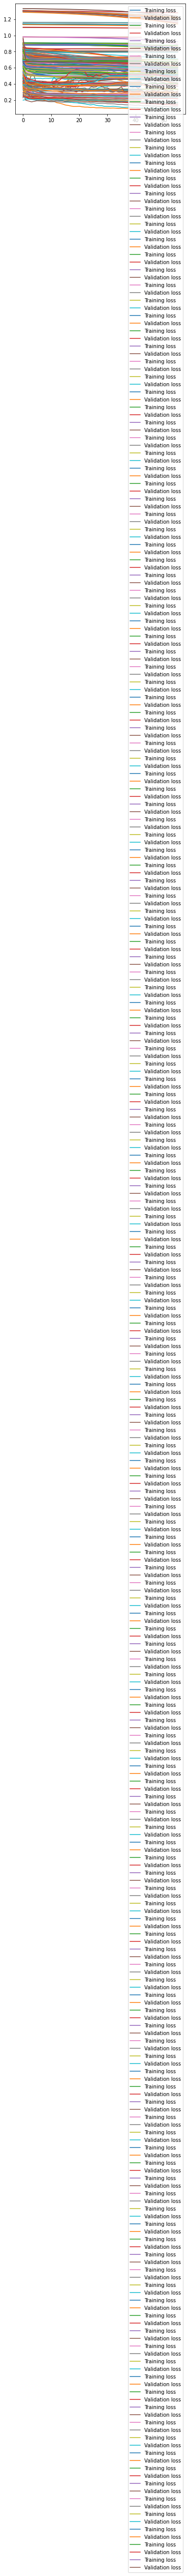

In [17]:
def _model(cmodel,units,activationDense,dropout1,dropout2,optimizer):
    model = Sequential()
    model.add(cmodel(units = units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=dropout1))
    model.add(cmodel(units = units, return_sequences=True))
    model.add(Dropout(rate=dropout2))
    model.add(TimeDistributed(Dense(1,kernel_initializer='normal',activation=activationDense)))
    model.compile(optimizer=optimizer, loss='mae')
    model.summary()
    
    return model

models = [LSTM,GRU]
nmodels = ["LSTM","GRU"]
sequences = ["1h","3h","6h","12h","1d", "3d", "7d"]
X_trains = [X_train1h,X_train3h, X_train6h, X_train12h,X_train1d,X_train3d, X_train7d]
y_trains= [y_train1h,y_train3h, y_train6h,y_train12h,y_train1d,y_train3d, y_train7d]
activations = ['relu']
activationsDense = ['tanh','sigmoid']
optimizers = ['adam','adadelta','adamax']
list_validationSplit = [0.1,0.2]
list_dropout1 =  np.random.uniform(0.1,0.8,5)   
list_dropout2 =  np.random.uniform(0.1,0.8,5)   
list_units = np.random.randint(6,high=100, size=5) 
list_epochs = np.random.randint(5,high=100, size=5)  
list_batchsize = np.random.randint(6,high=64, size=5)    

list_results = pd.DataFrame()

for cmodel,nmodel in zip(models,nmodels):
    for X_train, y_train,sequence in zip(X_trains,y_trains,sequences):
        for optimizer in optimizers:
            #for activation in activations:
                for activationDense in activationsDense:
                    for units,epochs,batchsize,dropout1,dropout2,validationsplit in zip(list_units,list_epochs,list_batchsize,list_dropout1,list_dropout2,list_validationSplit): 
                        start = time()
                        print("###########################\n")
                        print("MODEL: ", nmodel)
                        print('sequence: ',sequence)
                        print('units: ',units)
                        print('dropout1: ',dropout1)
                        print('dropout2: ',dropout2)
                        print('optimizer:',optimizer)
                        #print('activation:',activation)
                        print('activationDense:',activationDense)
                        print('epochs:',epochs)
                        print('batchsize:',batchsize)
                        print('validation_split:',validationsplit)
                    
                        model = _model(cmodel,units,activationDense,dropout1,dropout2,optimizer)
                        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, validation_split=validationsplit, shuffle=False)
                        end = time()
                        totalTime = end-start
                        print ('Execution time: ',totalTime)

                        import matplotlib.pyplot as plt
                        plt.plot(history.history['loss'], label='Training loss')
                        plt.plot(history.history['val_loss'], label='Validation loss')
                        plt.legend();

                        X_train_pred = model.predict(X_train, verbose=0)
                        
                        mae,rmse,mse = evaluate_prediction(X_train_pred, X_train,nmodel)
                        
                        print('Train RMSE: %.3f' % rmse);
                        print('Train MSE: %.3f' % mse);
                        print('Train MAE: %.3f' % mae);
                        
                        result = pd.DataFrame({
                                               #'activation':[activation],
                                               'model':[nmodel],
                                               'sequence':[sequence],
                                               'activationDense':[activationDense],
                                               'optimizer':[optimizer],
                                               'dropout1':[dropout1],
                                               'dropout2':[dropout2],
                                               'units':[units],
                                               'epochs':[epochs],
                                               'batchsize':[batchsize],
                                               'validation_split':[validationsplit],
                                               
                                               'RMSE':[rmse],
                                               'MSE':[mse],
                                               'MAE':[mae],                            
                                               'Time':[totalTime]})
                        list_results = list_results.append(result) 

In [18]:
list_results.to_csv("resultats-cerca-optim-lstm-dues-capes.csv")

In [19]:
list_results.head(20)

,model,sequence,activationDense,optimizer,dropout1,dropout2,units,epochs,batchsize,validation_split,RMSE,MSE,MAE,Time
0,LSTM,1h,tanh,adam,0.405196,0.331234,43,56,11,0.1,0.574725,0.330309,0.165477,92.219330
0,LSTM,1h,tanh,adam,0.118148,0.243254,45,43,30,0.2,0.573424,0.328815,0.155201,40.125178
0,LSTM,1h,sigmoid,adam,0.405196,0.331234,43,56,11,0.1,0.750276,0.562914,0.490691,89.099901
0,LSTM,1h,sigmoid,adam,0.118148,0.243254,45,43,30,0.2,0.751313,0.564471,0.492566,41.000820
0,LSTM,1h,tanh,adadelta,0.405196,0.331234,43,56,11,0.1,0.961165,0.923839,0.660268,88.287473
0,LSTM,1h,tanh,adadelta,0.118148,0.243254,45,43,30,0.2,0.990478,0.981046,0.704085,41.589166
0,LSTM,1h,sigmoid,adadelta,0.405196,0.331234,43,56,11,0.1,1.103773,1.218315,0.915444,90.688455
0,LSTM,1h,sigmoid,adadelta,0.118148,0.243254,45,43,30,0.2,1.113190,1.239192,0.926062,41.509876
0,LSTM,1h,tanh,adamax,0.405196,0.331234,43,56,11,0.1,0.574382,0.329915,0.162329,91.402002
0,LSTM,1h,tanh,adamax,0.118148,0.243254,45,43,30,0.2,0.575712,0.331444,0.163877,41.700037


In [20]:
list_results.sort_values(by=['RMSE', 'sequence'])

,model,sequence,activationDense,optimizer,dropout1,dropout2,units,epochs,batchsize,validation_split,RMSE,MSE,MAE,Time
0,LSTM,1h,tanh,adam,0.118148,0.243254,45,43,30,0.2,0.573424,0.328815,0.155201,40.125178
0,GRU,1h,tanh,adam,0.118148,0.243254,45,43,30,0.2,0.573611,0.329030,0.157387,43.191447
0,LSTM,1h,tanh,adamax,0.405196,0.331234,43,56,11,0.1,0.574382,0.329915,0.162329,91.402002
0,GRU,1h,tanh,adam,0.405196,0.331234,43,56,11,0.1,0.574710,0.330291,0.169553,84.436389
0,LSTM,1h,tanh,adam,0.405196,0.331234,43,56,11,0.1,0.574725,0.330309,0.165477,92.219330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,GRU,7d,tanh,adam,0.405196,0.331234,43,56,11,0.1,1.150011,1.322525,0.688702,6012.788527
0,LSTM,7d,tanh,adam,0.118148,0.243254,45,43,30,0.2,1.156215,1.336834,0.672385,2708.811306
0,GRU,7d,tanh,adamax,0.118148,0.243254,45,43,30,0.2,1.159410,1.344231,0.678044,2915.387079
0,GRU,7d,tanh,adam,0.118148,0.243254,45,43,30,0.2,1.177376,1.386213,0.722471,2853.544449
